## Low-bit SGD

https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

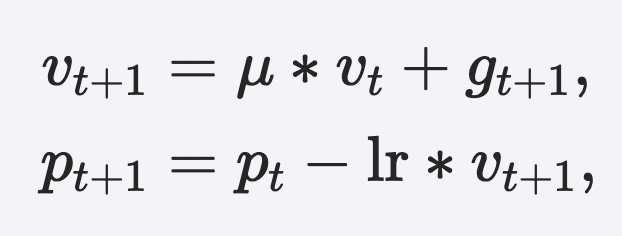

In [2]:
import torch
from torch import Tensor

def sgd(p: Tensor, grad: Tensor, momentum_buffer: Tensor, lr: float, momentum: float):
    new_momentum_buffer = momentum_buffer * momentum + grad
    new_p = p - lr * new_momentum_buffer

    momentum_buffer.copy_(new_momentum_buffer)
    p.copy_(new_p)

lr = 1e-4
momentum = 0.9

torch.manual_seed(2024)
p = torch.randn(4, 4)
momentum_buffer = torch.randn(4, 4)

for _ in range(5):
    grad = torch.randn(4, 4)
    sgd(p, grad, momentum_buffer, lr, momentum)
p

tensor([[-1.2276, -0.0069,  1.5427, -0.4662],
        [ 0.2781, -0.2610,  0.6238, -1.1576],
        [ 0.1165, -1.8872,  2.1816, -0.1922],
        [ 0.5355, -0.8906, -0.3107,  0.7731]])

SGD with BF16 optim state

In [3]:
def sgd_bf16(p: Tensor, grad: Tensor, momentum_buffer: Tensor, lr: float, momentum: float):
    # upcast to FP32 for accurate calculations
    new_momentum_buffer = momentum_buffer.float() * momentum + grad
    new_p = p - lr * new_momentum_buffer

    momentum_buffer.copy_(new_momentum_buffer)  # implicit downcast to BF16
    p.copy_(new_p)

torch.manual_seed(2024)
p = torch.randn(4, 4)
grad = torch.randn(4, 4)
momentum_buffer = torch.randn(4, 4).bfloat16()

for _ in range(5):
    grad = torch.randn(4, 4)
    sgd_bf16(p, grad, momentum_buffer, lr, momentum)
p

tensor([[-1.2275, -0.0075,  1.5428, -0.4662],
        [ 0.2787, -0.2601,  0.6238, -1.1572],
        [ 0.1170, -1.8873,  2.1821, -0.1927],
        [ 0.5361, -0.8902, -0.3104,  0.7732]])

SGD with FP8 optim state

In [4]:
def sgd_fp8(p: Tensor, grad: Tensor, momentum_buffer: Tensor, lr: float, momentum: float):
    # upcast to FP32 for accurate calculations
    new_momentum_buffer = momentum_buffer.float() * momentum + grad
    new_p = p - lr * new_momentum_buffer

    momentum_buffer.copy_(new_momentum_buffer)  # implicit downcast to FP8
    p.copy_(new_p)

torch.manual_seed(2024)
p = torch.randn(4, 4)
grad = torch.randn(4, 4)
momentum_buffer = torch.randn(4, 4).to(torch.float8_e4m3fn)

for _ in range(5):
    grad = torch.randn(4, 4)
    sgd_fp8(p, grad, momentum_buffer, lr, momentum)
p

tensor([[-1.2275, -0.0075,  1.5427, -0.4662],
        [ 0.2787, -0.2601,  0.6238, -1.1572],
        [ 0.1170, -1.8873,  2.1821, -0.1927],
        [ 0.5361, -0.8902, -0.3104,  0.7732]])

SGD with scaled FP8 optim state (tensor-wise scaling)

In [5]:
DTYPE = torch.float8_e4m3fn

def quantize_fp8(x: Tensor):
    scale = x.abs().max() / torch.finfo(DTYPE).max
    quantized_x = (x / scale.clip(1e-12)).to(DTYPE)
    return quantized_x, scale

def sgd_scaled_fp8(
    p: Tensor,
    grad: Tensor,
    momentum_buffer: Tensor,
    momentum_buffer_scale: Tensor,
    lr: float,
    momentum: float,
):
    # upcast to FP32 for accurate calculations
    new_momentum_buffer = momentum_buffer.float() * momentum_buffer_scale * momentum + grad
    new_p = p - lr * new_momentum_buffer

    new_momentum_buffer_quantized, new_momentum_buffer_scale = quantize_fp8(new_momentum_buffer)
    momentum_buffer.copy_(new_momentum_buffer_quantized)
    momentum_buffer_scale.copy_(new_momentum_buffer_scale)
    p.copy_(new_p)

torch.manual_seed(2024)
p = torch.randn(4, 4)
grad = torch.randn(4, 4)
momentum_buffer = torch.randn(4, 4)
momentum_buffer, momentum_buffer_scale = quantize_fp8(momentum_buffer)

for _ in range(5):
    grad = torch.randn(4, 4)
    sgd_scaled_fp8(p, grad, momentum_buffer, momentum_buffer_scale, lr, momentum)
p

tensor([[-1.2275, -0.0075,  1.5427, -0.4661],
        [ 0.2787, -0.2602,  0.6238, -1.1573],
        [ 0.1170, -1.8873,  2.1821, -0.1927],
        [ 0.5361, -0.8902, -0.3104,  0.7731]])

## Stochastic rounding

Small changes in to a low-bit data won't change its value.

In [31]:
import torch

# INT8 + small fraction

x = torch.tensor(10, dtype=torch.int8)
N = 100
for _ in range(N):
    x.copy_(x + 0.2)

print(f"Expected output: {10 + 0.2 * N}")
print(f"Actual output: {x}")

Expected output: 30.0
Actual output: 10


$x$ will be rounded up to $\lfloor x \rfloor + 1$ with the probability of $(x - \lfloor x \rfloor)$, otherwise it is rounded down to $\lfloor x \rfloor + 1$.

In [38]:
def sr(x: torch.Tensor):
    rand = torch.rand(x.shape, device=x.device)  # get a random number [0,1)
    return torch.where(rand < x - x.floor(), x.floor() + 1, x.floor())

x = torch.tensor(10, dtype=torch.int8)
N = 100
for _ in range(N):
    x.copy_(sr(x.float() + 0.2))

print(f"Expected output: {10 + 0.2 * N}")
print(f"Actual output: {x}")

Expected output: 30.0
Actual output: 32


## Stochastic rounding for BF16

<img src="https://i0.wp.com/semiengineering.com/wp-content/uploads/2019/10/Flex-Logix_BFloat16-fig1.png" width=500>

BF16 = FP32 with truncated mantissa bits. To do SR from FP32 -> BF16, we can do integer arithmetics on the mantissa bits

In [21]:
x = torch.tensor(200, dtype=torch.bfloat16)
N = 100
for _ in range(N):
    x.copy_(x + 1)

print(f"Expected output: {200 + N}")
print(f"Actual output: {x}")

Expected output: 300
Actual output: 256.0


In [30]:
def bf16_sr(x: torch.Tensor):  # x is FP32
    x_i32 = x.view(torch.int32)  # cast to INT32 to do bit manipulation
    x_floor = x_i32 & 0xFFFF0000  # truncate the least significant 16 bits

    # this will generate 31 random bits. we only need 16
    rand = torch.empty(x.shape, dtype=torch.int32).random_()
    rand = rand & 0xFFFF

    out = torch.where(rand < (x_i32 & 0xFFFF), x_floor + 0x10000, x_floor)
    return out.view(torch.float32).bfloat16()

x = torch.tensor(200, dtype=torch.bfloat16)
N = 100
for _ in range(N):
    x.copy_(bf16_sr(x.float() + 1))

print(f"Expected output: {200 + N}")
print(f"Actual output: {x}")

Expected output: 300
Actual output: 300.0
